### Assignment 12

Using section 8.4 in Deep Learning with Python as a guide, implement a variational autoencoder using the MNIST data set and save a grid of 15 x 15 digits to the results/vae directory. If you would rather work on a more interesting dataset, you can use the CelebFaces Attributes Dataset instead.

In [7]:
# Load required packages
import tensorflow as tf
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from scipy.stats import norm

# tf.config.run_functions_eagerly(True)
tf.compat.v1.disable_eager_execution()

In [8]:
# build VAE encoder network

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape = img_shape)

x = layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(input_img)

x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x)

x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu')(x)

x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)

x = layers.Dense(32, activation = 'relu')(x)

# encode input image into parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [9]:
# latent-space-sampling function

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean = 0., stddev = 1.)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [10]:
# build VAE decoder network, mapping latent space points to images

decoder_input = layers.Input(K.int_shape(z)[1:]) # feed in z

# upsample input
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation = 'relu')(decoder_input)

# reshape z into feature map same shape as feature map before flattening in encoder
x = layers.Reshape(shape_before_flattening[1:])(x)

# decode z into feature map same as original image
x = layers.Conv2DTranspose(32, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x)

x = layers.Conv2D(1, 3, padding = 'same', activation = 'sigmoid')(x)

# instantiate decoder model (turn input into decoded image)
decoder = Model(decoder_input, x)

# recover decoded z
z_decoded = decoder(z)

In [11]:
# custom layer to compute VAE loss

class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        k1_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
        
        return K.mean(xent_loss + k1_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs = inputs)
        
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [12]:
# train vae

vae = Model(input_img, y)
vae.compile(optimizer = 'rmsprop', loss = None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x = x_train,
        y = None,
       shuffle = True,
       epochs = 5,
       batch_size = batch_size,
       validation_data = (x_test, None))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
____________________________________________________________________________________________

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 87s 1ms/sample - loss: 19519.7078 - val_loss: 0.1991
Epoch 2/5
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.1960 - val_loss: 0.1926
Epoch 3/5
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.1908 - val_loss: 0.1890
Epoch 4/5
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.1882 - val_loss: 0.1865
Epoch 5/5
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.1865 - val_loss: 0.1854


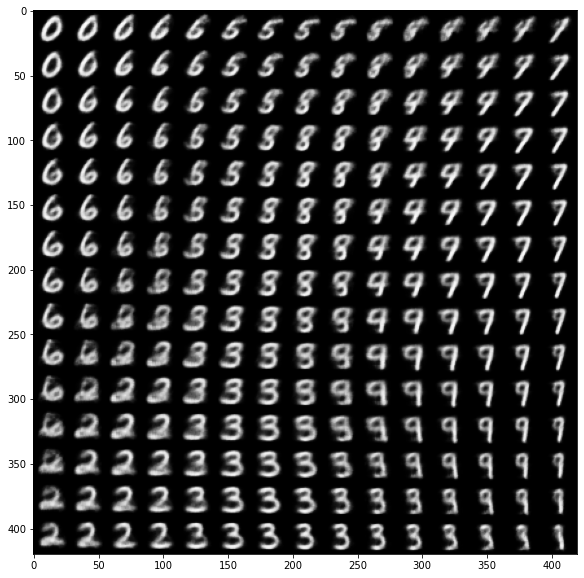

<Figure size 432x288 with 0 Axes>

In [17]:
# plot grid of decoded images from 2D latent space 

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([xi, yi])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size = batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize = (10, 10))
plt.imshow(figure, cmap = 'Greys_r')
plt.show()

import os
from pathlib import Path
current_dir = Path(os.getcwd()).absolute()
results_dir = current_dir.joinpath('results')
results_dir.mkdir(parents=True, exist_ok=True)
vae_dir = results_dir.joinpath('vae')
vae_dir.mkdir(parents=True, exist_ok=True)

plt.savefig('results/vae/vae_grid.png')